<a href="https://colab.research.google.com/github/CPCLAB-UNIPI/FrontSeatSummerSchool/blob/main/Ex_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for System Identification
## FrontSeat Summer School 2024

In this exercise, you will test the use of [neuromancer](https://github.com/pnnl/neuromancer) package to obtain neural network models for [two tank system](https://apmonitor.com/do/index.php/Main/LevelControl). The first model is NODE and the second model is NSSM.
If you run the whole code you will see that the code is working, but the results are unsatisfactory. Your task is to find the combination of parameters that will improve the results of both models.

In [1]:
!pip install neuromancer

In [2]:
import torch
import torch.nn as nn
from neuromancer.psl import plot
from neuromancer import psl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np

from neuromancer.system import Node, System
from neuromancer.dynamics import integrators, ode
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.loggers import BasicLogger
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks

# Fix seeds for reproducibility
np.random.seed(0)
torch.manual_seed(0)

The first step is to obtain data. In this case we use the build in emulator in neuromancer package to create a set of data performing step changes of control variables.



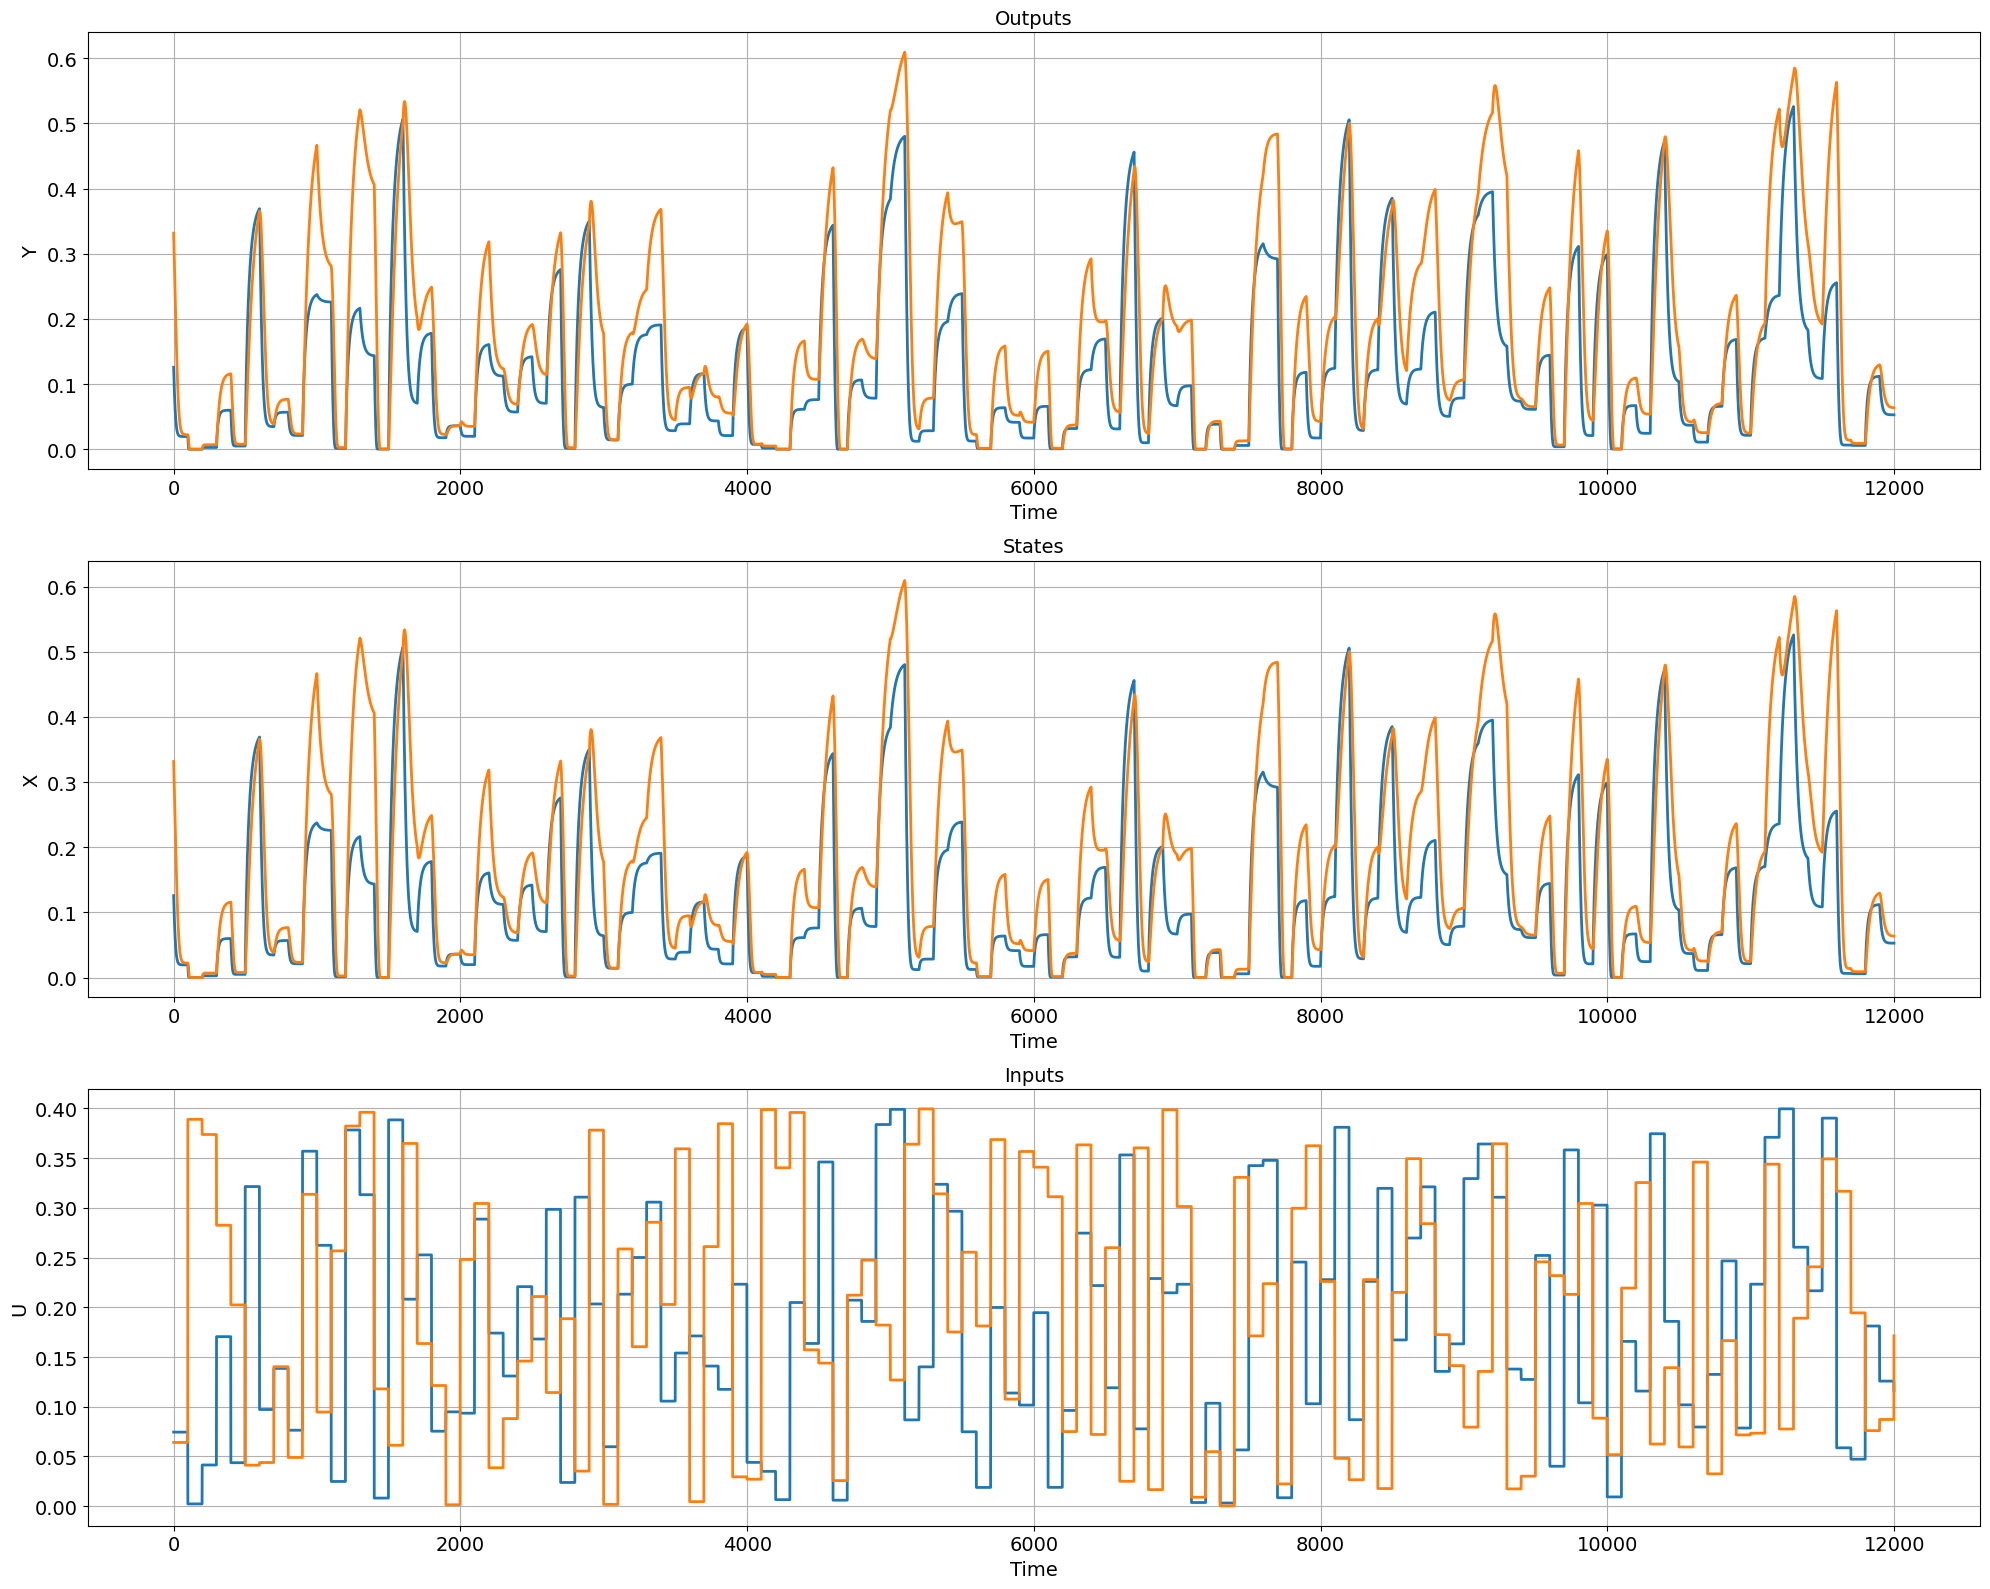

In [3]:
# %%  ground truth system
system_name = 'TwoTank'
system = psl.systems[system_name]
modelSystem = system()
ts = modelSystem.ts
nx = modelSystem.nx
nu = modelSystem.nu
nsim = 12000
raw = modelSystem.simulate(nsim=nsim, ts=ts)
plot.pltOL(Y=raw['Y'], X=raw['X'], U=raw['U'])



Here we split dataset into three groups train-test-validation which will be stored in dictionaries, normalize them. You can adjust the size of each group, number of prediction horizon steps and batch sizes.

In [4]:
def get_data(sys, data, nsim, nsteps, ts, bs, dev_percent, test_percent):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size
    :param dev_percent: (float) Percentage of data to use for the development set (0.0 - 1.0)
    :param test_percent: (float) Percentage of data to use for the test set (0.0 - 1.0)
    """
    # Ensure the percentages are valid
    if dev_percent + test_percent >= 1.0:
        raise ValueError("The sum of dev_percent and test_percent should be less than 1.0.")

    # Calculate the number of samples for train, dev, and test
    n_dev = int(dev_percent * nsim)
    n_test = int(test_percent * nsim)
    n_train = nsim - (n_dev + n_test)

    # Get data from our simulation
    sim_data = data
    nx = sys.nx
    nu = sys.nu

    # Adjust the lengths to make sure they are multiples of nsteps
    n_train -= n_train % nsteps
    n_dev -= n_dev % nsteps
    n_test -= n_test % nsteps

    # Slice the data based on the specified lengths
    train_data_sim = {'X': sim_data['X'][:n_train], 'U': sim_data['U'][:n_train]}
    dev_data_sim = {'X': sim_data['X'][n_train:(n_train + n_dev)], 'U': sim_data['U'][n_train:(n_train + n_dev)]}
    test_data_sim = {'X': sim_data['X'][(n_train + n_dev):(n_train + n_dev + n_test)], 'U': sim_data['U'][(n_train + n_dev):(n_train + n_dev + n_test)]}

    # Prepare training data
    trainX = train_data_sim['X']
    trainX = trainX.reshape(-1, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU = train_data_sim['U']
    trainU = trainU.reshape(-1, nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    train_data = DictDataset({'X': trainX, 'xn': trainX[:, 0:1, :],
                              'U': trainU}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)

    # Prepare dev/validation data
    devX = dev_data_sim['X']
    devX = devX.reshape(-1, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    devU = dev_data_sim['U']
    devU = devU.reshape(-1, nsteps, nu)
    devU = torch.tensor(devU, dtype=torch.float32)
    dev_data = DictDataset({'X': devX, 'xn': devX[:, 0:1, :],
                            'U': devU}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    # Prepare test data
    testX = test_data_sim['X']
    testX = testX.reshape(1, -1, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    testU = test_data_sim['U']
    testU = testU.reshape(1, -1, nu)
    testU = torch.tensor(testU, dtype=torch.float32)
    test_data = {'X': testX, 'xn': testX[:, 0:1, :],
                 'U': testU}

    # Plotting
    plt.figure(figsize=(20,10))
    plt.plot(range(n_train), train_data_sim['X'], color='blue', label='Train')
    plt.plot(range(n_train, n_train + n_dev), dev_data_sim['X'], color='orange', label='Dev')
    plt.plot(range(n_train + n_dev, n_train + n_dev + n_test), test_data_sim['X'], color='green', label='Test')
    plt.title('Train, Dev, Test Data Split')
    plt.xlabel('Time')
    plt.ylabel('x1,x2')
    plt.grid()
    plt.show()

    return train_loader, dev_loader, test_data


Feel free to adjust nsteps and batch size.

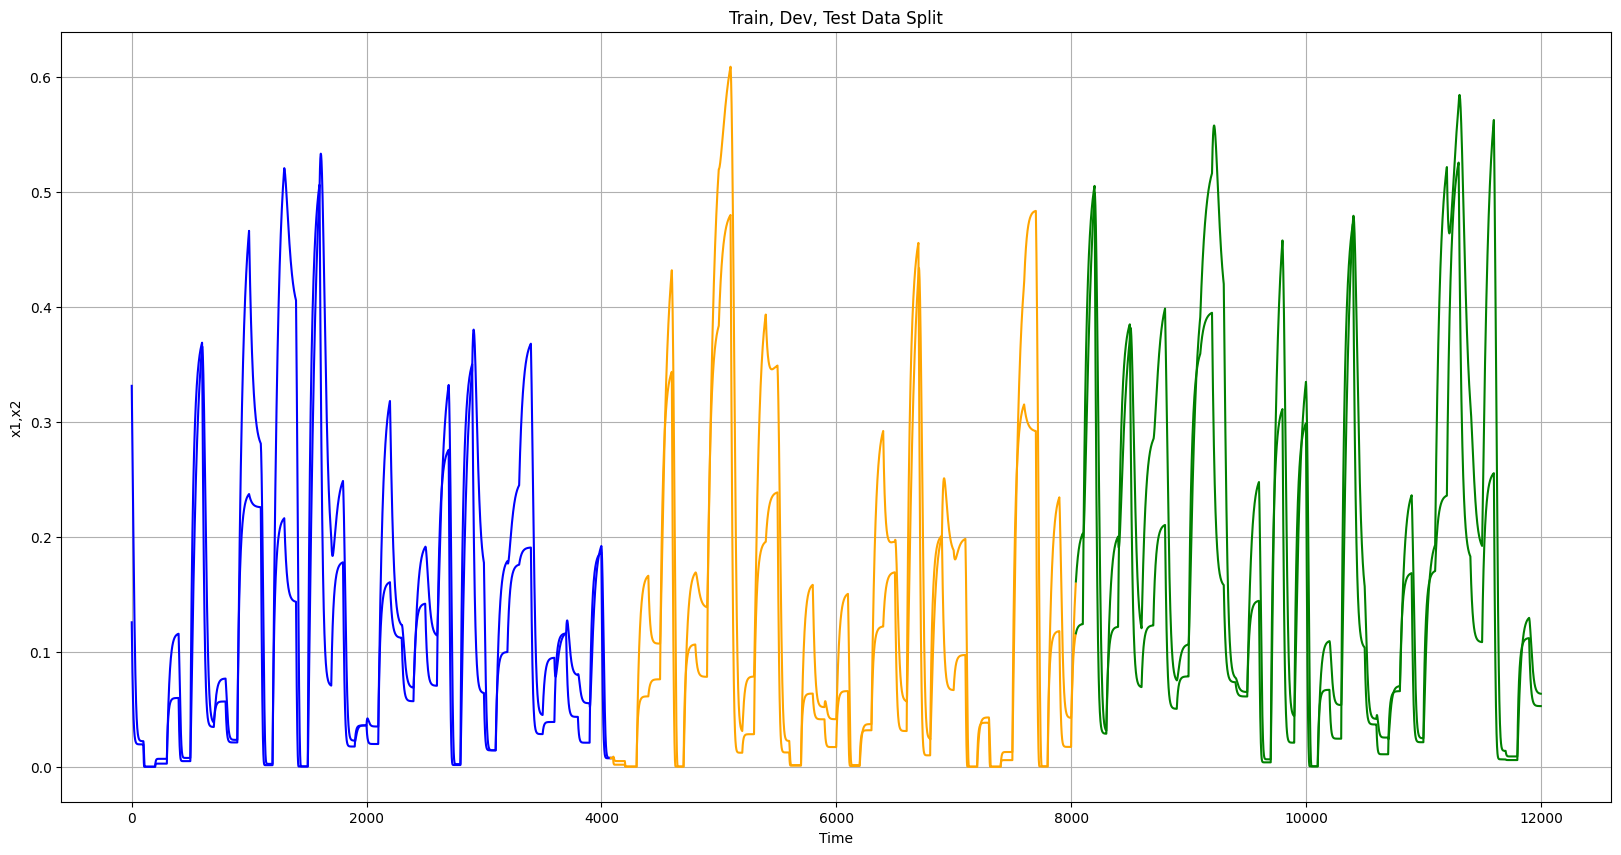

In [5]:
nsteps = 5  # number of prediction horizon steps in the loss function
bs = 10     # minibatching batch size
train_loader, dev_loader, test_data = get_data(modelSystem, raw, nsim, nsteps, ts, bs, .33, .33)

## NODE system model in Neuromancer

Here, a NODE model is constructed: $\dot{x} = f_{\theta}(x, u)$ with trainable parameters of a neural network $\theta$. You can adjust the number of hidden layers or number of neurons in each. Also, you can change the nonlinear activation function such as:

* ReLU (torch.nn.ReLU)
* LeakyReLU (torch.nn.LeakyReLU)
* PReLU (torch.nn.PReLU)
* ELU (torch.nn.ELU)
* SELU (torch.nn.SELU)
* GELU (torch.nn.GELU)
* Tanh (torch.nn.Tanh)
* Sigmoid (torch.nn.Sigmoid)
* Softplus (torch.nn.Softplus)
* ...


In [6]:
# define neural network of the NODE
fx = blocks.MLP(nx+nu, nx, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.Softplus,
                 hsizes=[2, 2])

Next, solving the continuous-time NODE model with a suitable ODE solver is required, e.g., Runge–Kutta integrator.

$x_{k+1} = \text{ODESolve}(f_{\theta}(x_k))$

For training, accurate reverse-mode gradients of the integrated ODE system are necessary. This can be done in two ways: either by unrolling the operations of the ODE solver and using the backpropagation through time (BPTT) algorithm, or via the Adjoint state method.

Neuromancer provides a set of ODE solvers. For the adjoint method, the interface to the open-source implementation is provided via the DiffEqIntegrator class. In this example, the BPTT algorithm through the unrolled RK4 solver will be used. If you are interested you may try also others such:

* Euler,
* Euler_Trap,
* RK2,
* RK4,
* RK4_Trap,
* Luther,
* Runge_Kutta_Fehlberg.






In [7]:
# integrate NODE with adjoint-based solver
fxRK4 = integrators.RK4(fx, h=ts)

Next we construct an open-loop system composed of a symbolic NODE model

In [8]:
# create symbolic system model in Neuromancer
model_NODE = Node(fxRK4, ['xn', 'U'], ['xn'], name='NODE')
dynamics_model_NODE = System([model_NODE], name='node_system', nsteps=nsteps)

## Define system identification loss function terms

The loss consists of the two parts:

$$\ell_x = Q_N||x^i_k - \hat{x}^i_k||_2^2$$

$$\ell_x = Q_1||x^i_1 - \hat{x}^i_1||_2^2$$

You can adjust the weighting on each loss.

In [9]:
# %% Constraints + losses:
x = variable("X")
xhat = variable('xn')[:, :-1, :]

Qn = 10.
Q1 = 1000.

# trajectory tracking loss
reference_loss = Qn*(xhat == x)^2
reference_loss.name = "ref_loss"

# one step tracking loss
onestep_loss = Q1*(xhat[:, 1, :] == x[:, 1, :])^2
onestep_loss.name = "onestep_loss"

## Construct System ID learning problem

Given the training dataset we want to solve the following problem:

$$
\begin{align}
&\underset{\theta}{\text{minimize}}     && \sum_{i=1}^m \Big(Q_1||x^i_1 - \hat{x}^i_1||_2^2 + \sum_{k=1}^{N}  Q_N||x^i_k - \hat{x}^i_k||_2^2   \Big) \\
&\text{subject to}    && x^i_{k+1} =  \text{ODESolve}(f_{\theta}(x^i_k, u^i_k)) \\
\end{align}
$$  

In [10]:
# aggregate list of objective terms and constraints
objectives = [reference_loss, onestep_loss]
constraints = []
# create constrained optimization loss
loss_NODE = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem_NODE = Problem([dynamics_model_NODE], loss_NODE)

## Solve the NODE problem

We fit the unknown NODE parameters $\theta$ using stochastic gradient descent. Here the parameter *lr* defins learning rate, try to change it. You can also adjust parameters of *patience*,*warmup* and *epochs*.

In [11]:
optimizer = torch.optim.Adam(problem_NODE.parameters(),
                             lr=0.1)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                     stdout=['dev_loss', 'train_loss'])

trainer = Trainer(
    problem_NODE,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=20,
    warmup=20,
    epochs=20,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    logger=logger,
)

None
Number of parameters: 22


In [12]:
# %% train
best_model = trainer.train()
problem_NODE.load_state_dict(best_model)

epoch: 0	train_loss: 0.02012	dev_loss: 0.00915	eltime:  3.09602
epoch: 1	train_loss: 0.00332	dev_loss: 0.00633	eltime:  6.36553
epoch: 2	train_loss: 0.01124	dev_loss: 0.00892	eltime:  9.94775
epoch: 3	train_loss: 0.00659	dev_loss: 0.00276	eltime:  11.31863
epoch: 4	train_loss: 0.00673	dev_loss: 0.00053	eltime:  12.52581
epoch: 5	train_loss: 0.02098	dev_loss: 0.01532	eltime:  13.74825
epoch: 6	train_loss: 0.02491	dev_loss: 0.01753	eltime:  14.99003
epoch: 7	train_loss: 0.00133	dev_loss: 0.00866	eltime:  16.19630
epoch: 8	train_loss: 0.00746	dev_loss: 0.01083	eltime:  17.39245
epoch: 9	train_loss: 0.00375	dev_loss: 0.00539	eltime:  18.69566
epoch: 10	train_loss: 0.02735	dev_loss: 0.00808	eltime:  20.20076
epoch: 11	train_loss: 0.00561	dev_loss: 0.00099	eltime:  22.00512
epoch: 12	train_loss: 0.00178	dev_loss: 0.00917	eltime:  23.49206
epoch: 13	train_loss: 0.00408	dev_loss: 0.00010	eltime:  24.74384
epoch: 14	train_loss: 0.01842	dev_loss: 0.00617	eltime:  25.92712
epoch: 15	train_loss: 0

<All keys matched successfully>

## Results NODE

In [13]:
# update the rollout length based on the test data
dynamics_model_NODE.nsteps = test_data['X'].shape[1]

# Test set results
test_outputs_NODE = dynamics_model_NODE(test_data)

pred_traj_NODE = test_outputs_NODE['xn'][:, :-1, :].detach().numpy().reshape(-1, nx)
true_traj = test_data['X'].detach().numpy().reshape(-1, nx)
input_traj = test_data['U'].detach().numpy().reshape(-1, nu)
pred_traj_NODE, true_traj = pred_traj_NODE.transpose(1, 0), true_traj.transpose(1, 0)

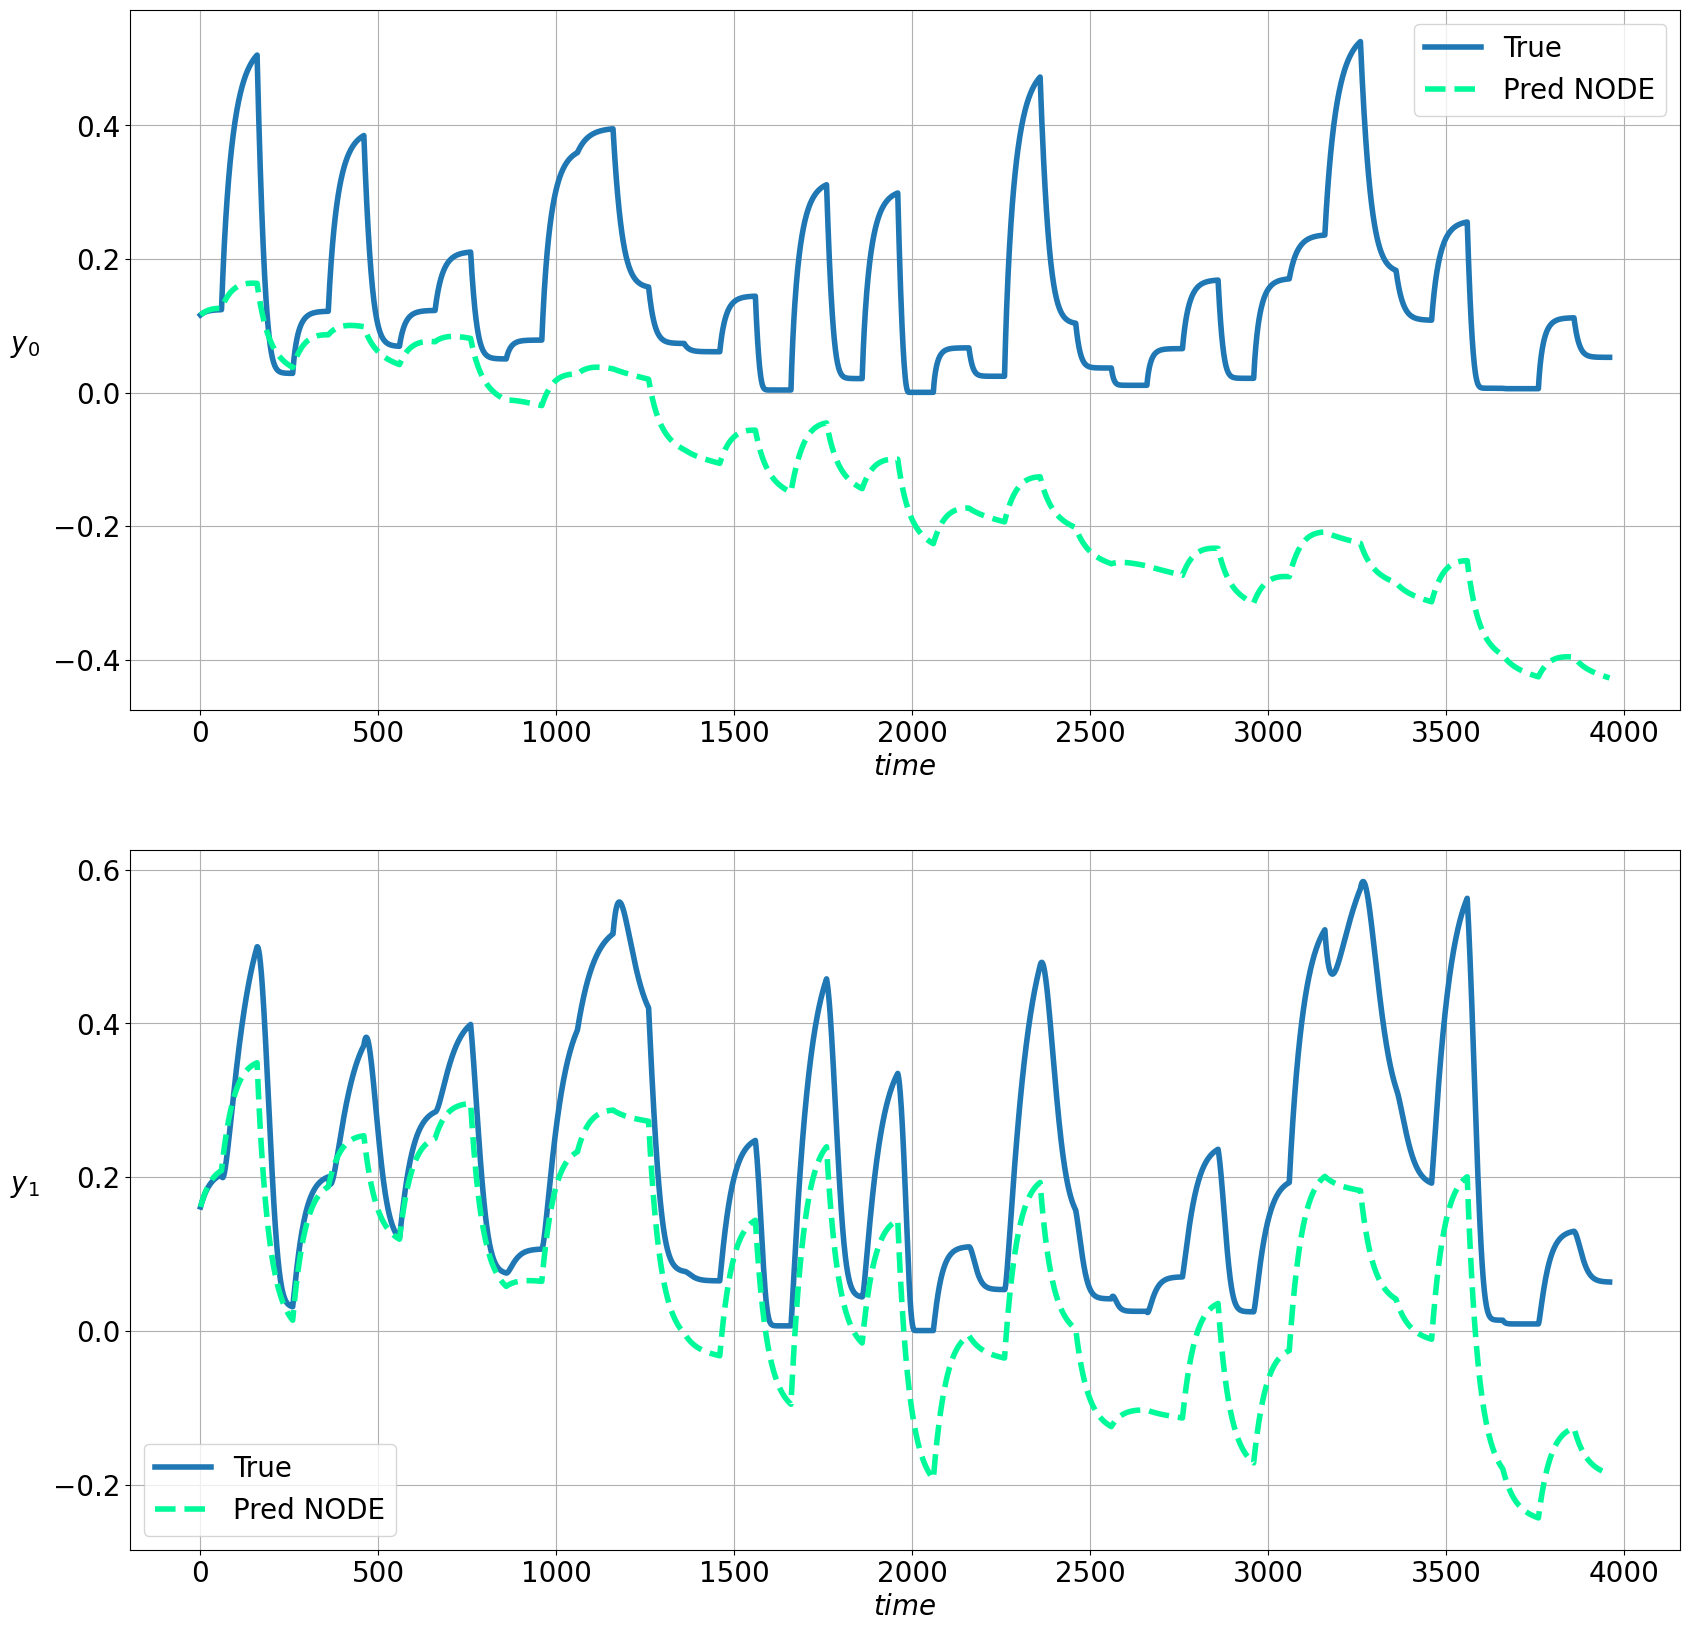

In [14]:
# plot rollout
figsize = 20
fig, ax = plt.subplots(nx, figsize=(figsize, figsize))
labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj_NODE, labels)):
    if nx > 1:
        axe = ax[row]
    else:
        axe = ax
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1, linewidth=4.0, label='True')
    axe.plot(t2, color='mediumspringgreen', linestyle='--', linewidth=4.0, label='Pred NODE')
    axe.tick_params(labelbottom=False, labelsize=figsize)
    axe.grid()
    axe.tick_params(labelbottom=True, labelsize=figsize)
    axe.legend(fontsize=figsize)
    axe.set_xlabel('$time$', fontsize=figsize)


## NSSM system model in Neuromancer

Here we construct a state space model  $x_{k+1} = A_{\theta}(x_k) + B_{\theta}(u_k) $ with $A$ and $B$ parametrized by neural networks with trainable parameters $\theta$.

In [15]:
# define the state space model as neural architecture
class NSSM(nn.Module):
    """
    Baseline class for (neural) state space model (SSM)
    Implements discrete-time dynamical system:
        x_k+1 = fx(x_k) + fu(u_k)
    with variables:
        x_k - states
        u_k - control inputs
    """
    def __init__(self, fx, fu, nx, nu):
        super().__init__()
        self.fx, self.fu = fx, fu
        self.nx, self.nu = nx, nu
        self.in_features, self.out_features = nx+nu, nx

    def forward(self, x, u, d=None):
        """
        :param x: (torch.Tensor, shape=[batchsize, nx])
        :param u: (torch.Tensor, shape=[batchsize, nu])
        :return: (torch.Tensor, shape=[batchsize, outsize])
        """
        # state space model
        x = self.fx(x) + self.fu(u)
        return x

Here, again you can adjust the number of hidden layers and number of neurons in each layer as well as the nonlinear activation function.

In [16]:
# instantiate neural nets
A = blocks.MLP(nx, nx, bias=True,
                 linear_map=torch.nn.Linear,
                 nonlin=torch.nn.Softplus,
                 hsizes=[2, 2])
B = blocks.MLP(nu, nx, bias=True,
                linear_map=torch.nn.Linear,
                nonlin=torch.nn.Softplus,
                hsizes=[2, 2])
# construct NSSM model in Neuromancer
ssm = NSSM(A, B, nx, nu)

For training, accurate reverse-mode gradients must be obtained by unrolling the operations of the NSSM and using the backpropagation through time (BPTT) algorithm. The number of steps (nsteps) to roll out the NSSM model can be specified in the symbolic System model in Neuromancer.

In [17]:
# create symbolic system model in Neuromancer
model_NSSM = Node(ssm, ['xn', 'U'], ['xn'], name='NSSM')
dynamics_model_NSSM = System([model_NSSM], name='system', nsteps=nsteps)

## Define system identification loss function terms

Again, we formulate multi-component loss as:

$$\ell_x = Q_N||x^i_k - \hat{x}^i_k||_2^2$$
$$\ell_x = Q_1||x^i_1 - \hat{x}^i_1||_2^2$$

In [18]:
# %% Constraints + losses:
x = variable("X")
xhat = variable('xn')[:, :-1, :]

mse_loss = nn.MSELoss()
QN = 1.
Q1 = 100.

# trajectory tracking loss
reference_loss = QN*(xhat == x)^2
reference_loss.name = "ref_loss"

# one step tracking loss
onestep_loss = Q1*(xhat[:, 1, :] == x[:, 1, :])^2
onestep_loss.name = "onestep_loss"

## Construct System ID learning problem

Given the training dataset we want to solve the following problem:

$$
\begin{align}
&\underset{\theta}{\text{minimize}}     && \sum_{i=1}^m \Big(Q_1||x^i_1 - \hat{x}^i_1||_2^2 + \sum_{k=1}^{N}  Q_N||x^i_k - \hat{x}^i_k||_2^2   \Big) \\
&\text{subject to}    && x^i_{k+1} = A_{\theta}(x_k^i) + B_{\theta}(u_k^i) \\
\end{align}
$$  

In [19]:
# aggregate list of objective terms and constraints
objectives = [reference_loss, onestep_loss]
constraints = []
# create constrained optimization loss
loss_NSSM = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem_NSSM = Problem([dynamics_model_NSSM], loss_NSSM)

## Solve the NSSM problem

We fit the unknown NSSM parameters $\theta$ using stochastic gradient descent.  You can also adjust parameters of *lr*, *patience*,*warmup* and *epochs*.



In [20]:
optimizer = torch.optim.Adam(problem_NSSM.parameters(),
                             lr=0.1)
logger = BasicLogger(args=None, savedir='test', verbosity=1,
                     stdout=['dev_loss', 'train_loss'])
# trainer
trainer = Trainer(
    problem_NSSM,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=20,
    warmup=20,
    epochs=20,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
    logger=logger
)

None
Number of parameters: 36


In [21]:
# %% train
best_model = trainer.train()
problem_NSSM.load_state_dict(best_model)

epoch: 0	train_loss: 0.09334	dev_loss: 0.72157	eltime:  0.71158
epoch: 1	train_loss: 0.20449	dev_loss: 0.12393	eltime:  1.43904
epoch: 2	train_loss: 0.27248	dev_loss: 0.22157	eltime:  2.11814
epoch: 3	train_loss: 0.16021	dev_loss: 0.38513	eltime:  2.79051
epoch: 4	train_loss: 0.04791	dev_loss: 0.25384	eltime:  3.46575
epoch: 5	train_loss: 0.19584	dev_loss: 0.12045	eltime:  4.11960
epoch: 6	train_loss: 0.05384	dev_loss: 0.04667	eltime:  4.78031
epoch: 7	train_loss: 0.06178	dev_loss: 0.01905	eltime:  5.42450
epoch: 8	train_loss: 0.06383	dev_loss: 1.25829	eltime:  6.07142
epoch: 9	train_loss: 0.03684	dev_loss: 0.01491	eltime:  6.77210
epoch: 10	train_loss: 0.01185	dev_loss: 0.01144	eltime:  7.40491
epoch: 11	train_loss: 0.05003	dev_loss: 0.01524	eltime:  8.10996
epoch: 12	train_loss: 0.03789	dev_loss: 0.04881	eltime:  9.13967
epoch: 13	train_loss: 0.15412	dev_loss: 0.04918	eltime:  10.21527
epoch: 14	train_loss: 0.04735	dev_loss: 0.19075	eltime:  11.24901
epoch: 15	train_loss: 0.02328	dev

<All keys matched successfully>

## Results NSSM

In [22]:
# update the rollout length based on the test data
dynamics_model_NSSM.nsteps = test_data['X'].shape[1]
# Test set results
test_outputs = dynamics_model_NSSM(test_data)

pred_traj_NSSM = test_outputs['xn'][:, :-1, :].detach().numpy().reshape(-1, nx)
true_traj = test_data['X'].detach().numpy().reshape(-1, nx)
input_traj = test_data['U'].detach().numpy().reshape(-1, nu)
pred_traj_NSSM, true_traj = pred_traj_NSSM.transpose(1, 0), true_traj.transpose(1, 0)

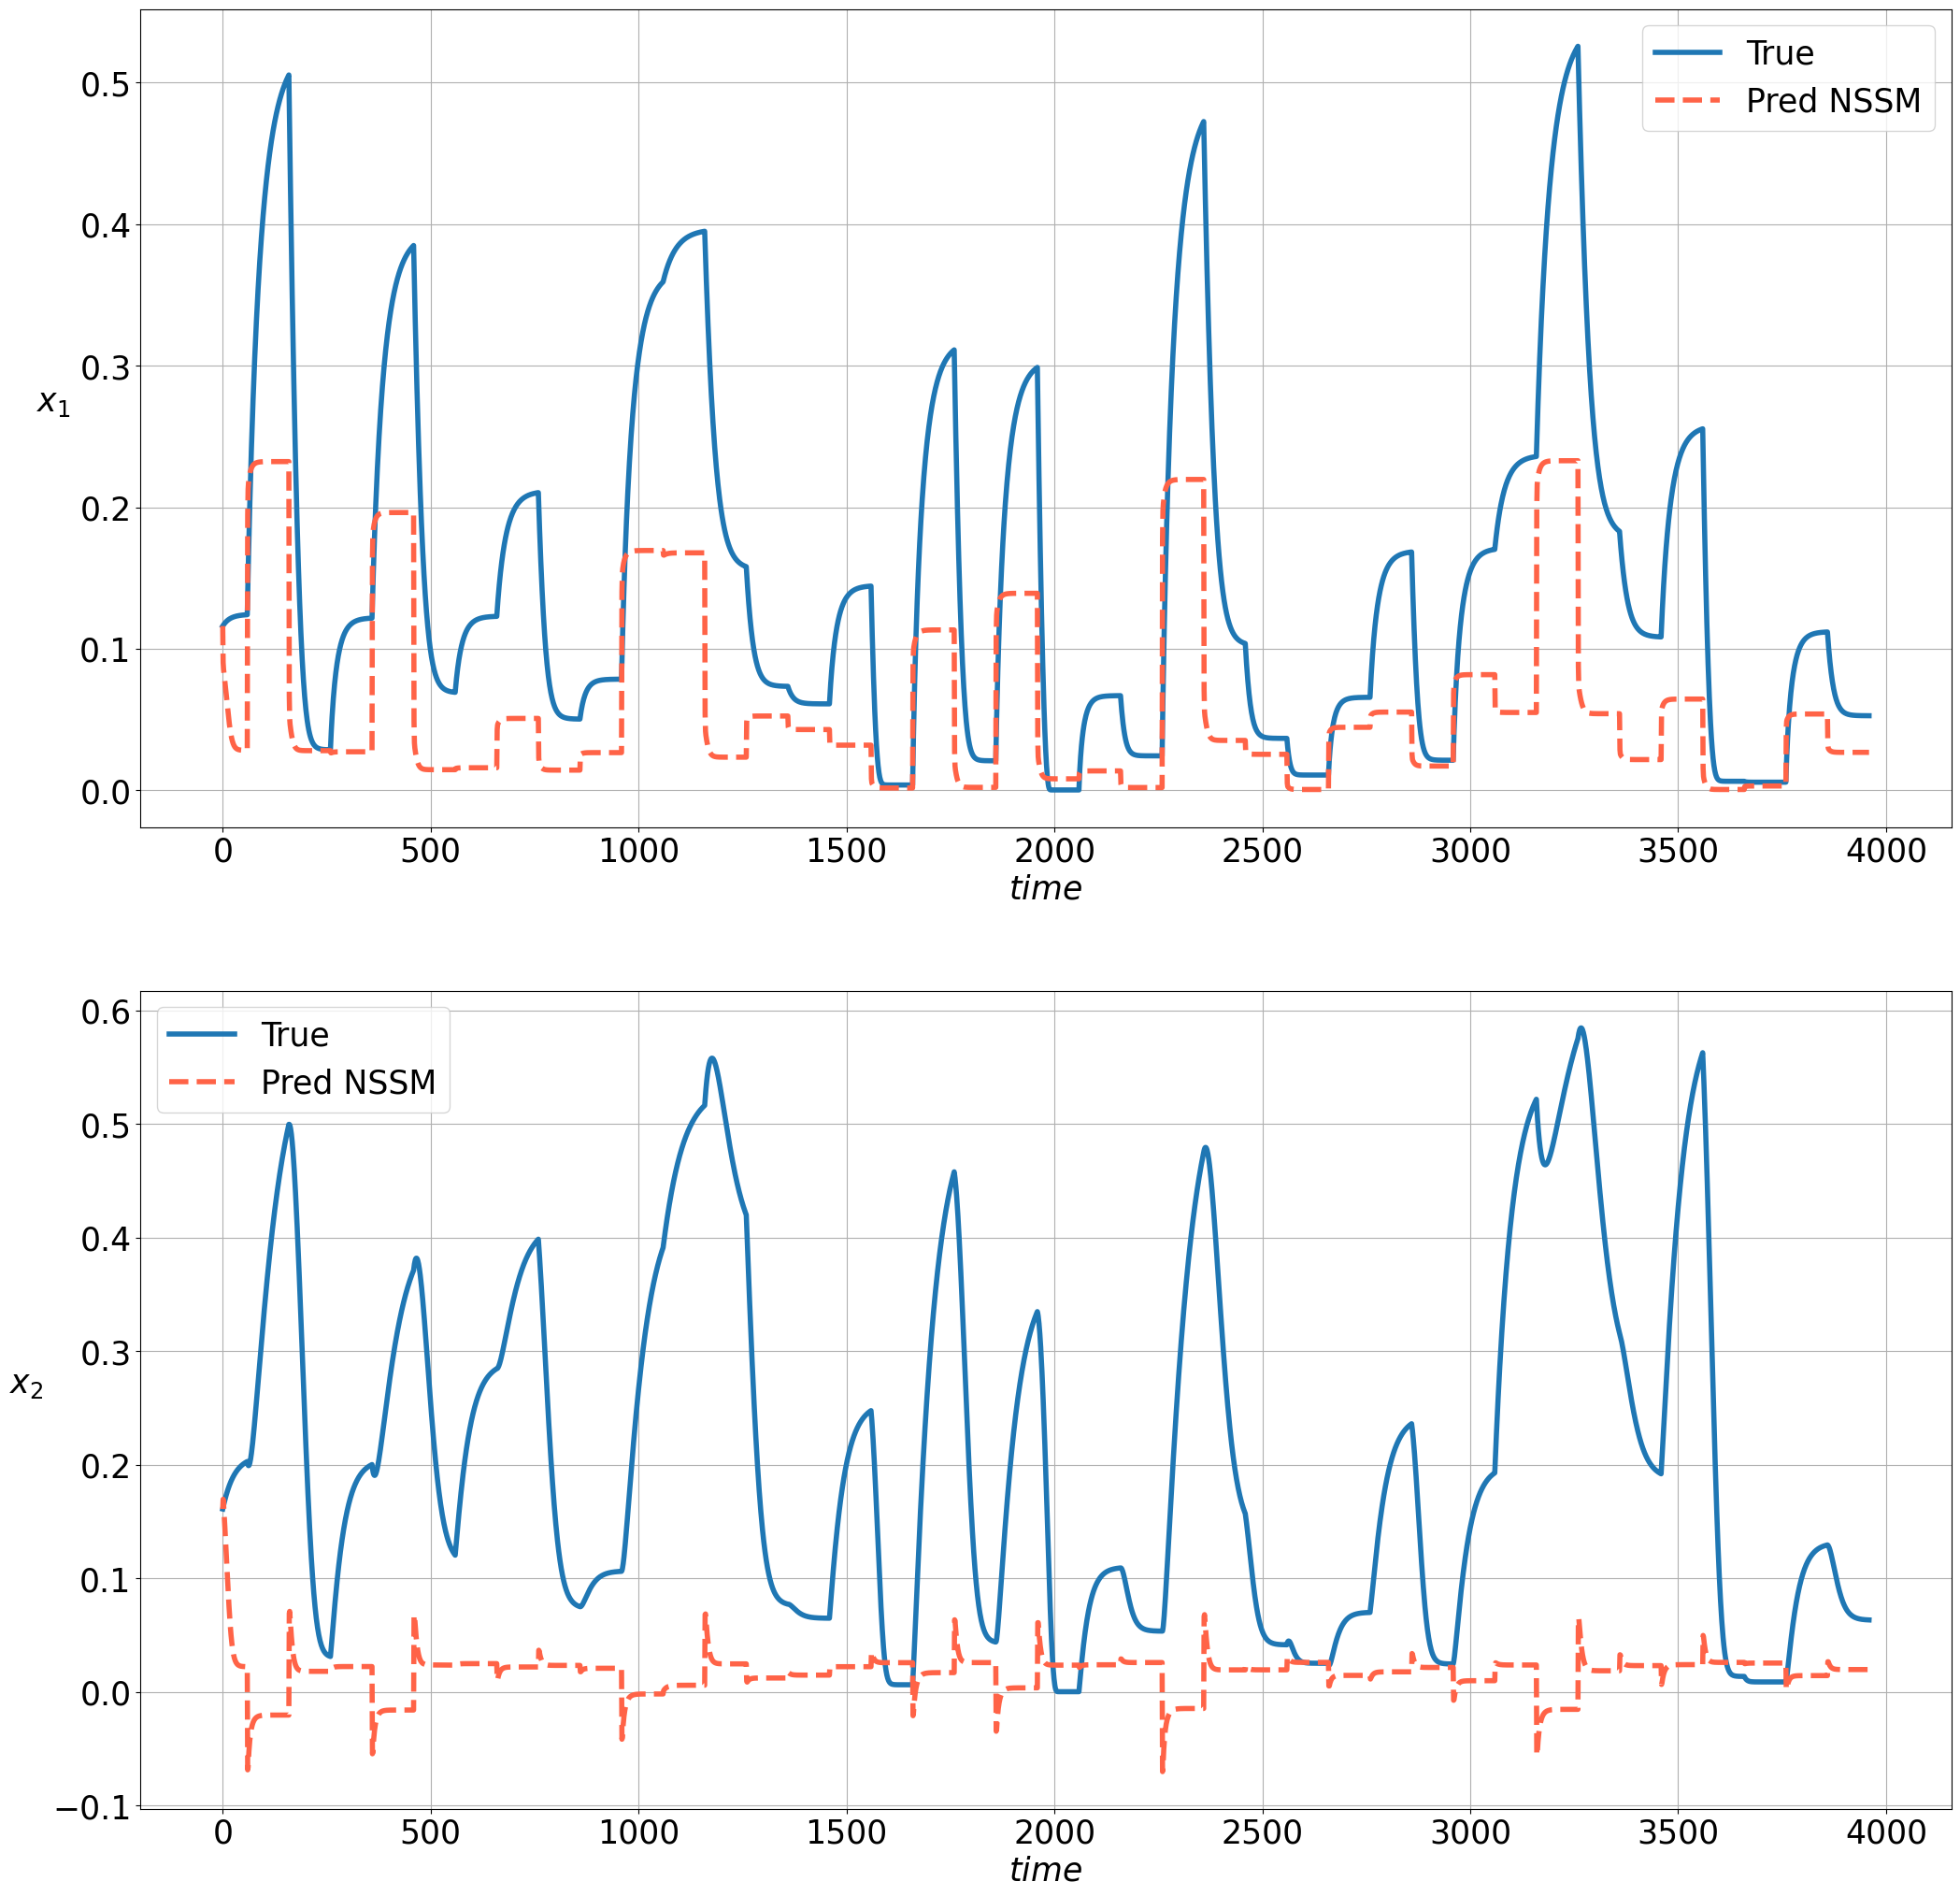

In [23]:
# plot rollout
figsize = 25
fig, ax = plt.subplots(nx, figsize=(figsize, figsize))
labels = [f'$x_{k+1}$' for k in range(len(true_traj))]
for row, (t1, t2, label) in enumerate(zip(true_traj, pred_traj_NSSM, labels)):
    if nx > 1:
        axe = ax[row]
    else:
        axe = ax
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1, linewidth=4.0, label='True')
    axe.plot(t2, color='tomato', linestyle='--', linewidth=4.0, label='Pred NSSM')
    axe.tick_params(labelbottom=False, labelsize=figsize)
    axe.grid()
    axe.tick_params(labelbottom=True, labelsize=figsize)
    axe.legend(fontsize=figsize)
    axe.set_xlabel('$time$', fontsize=figsize)


##Compare NODE and NSSSM

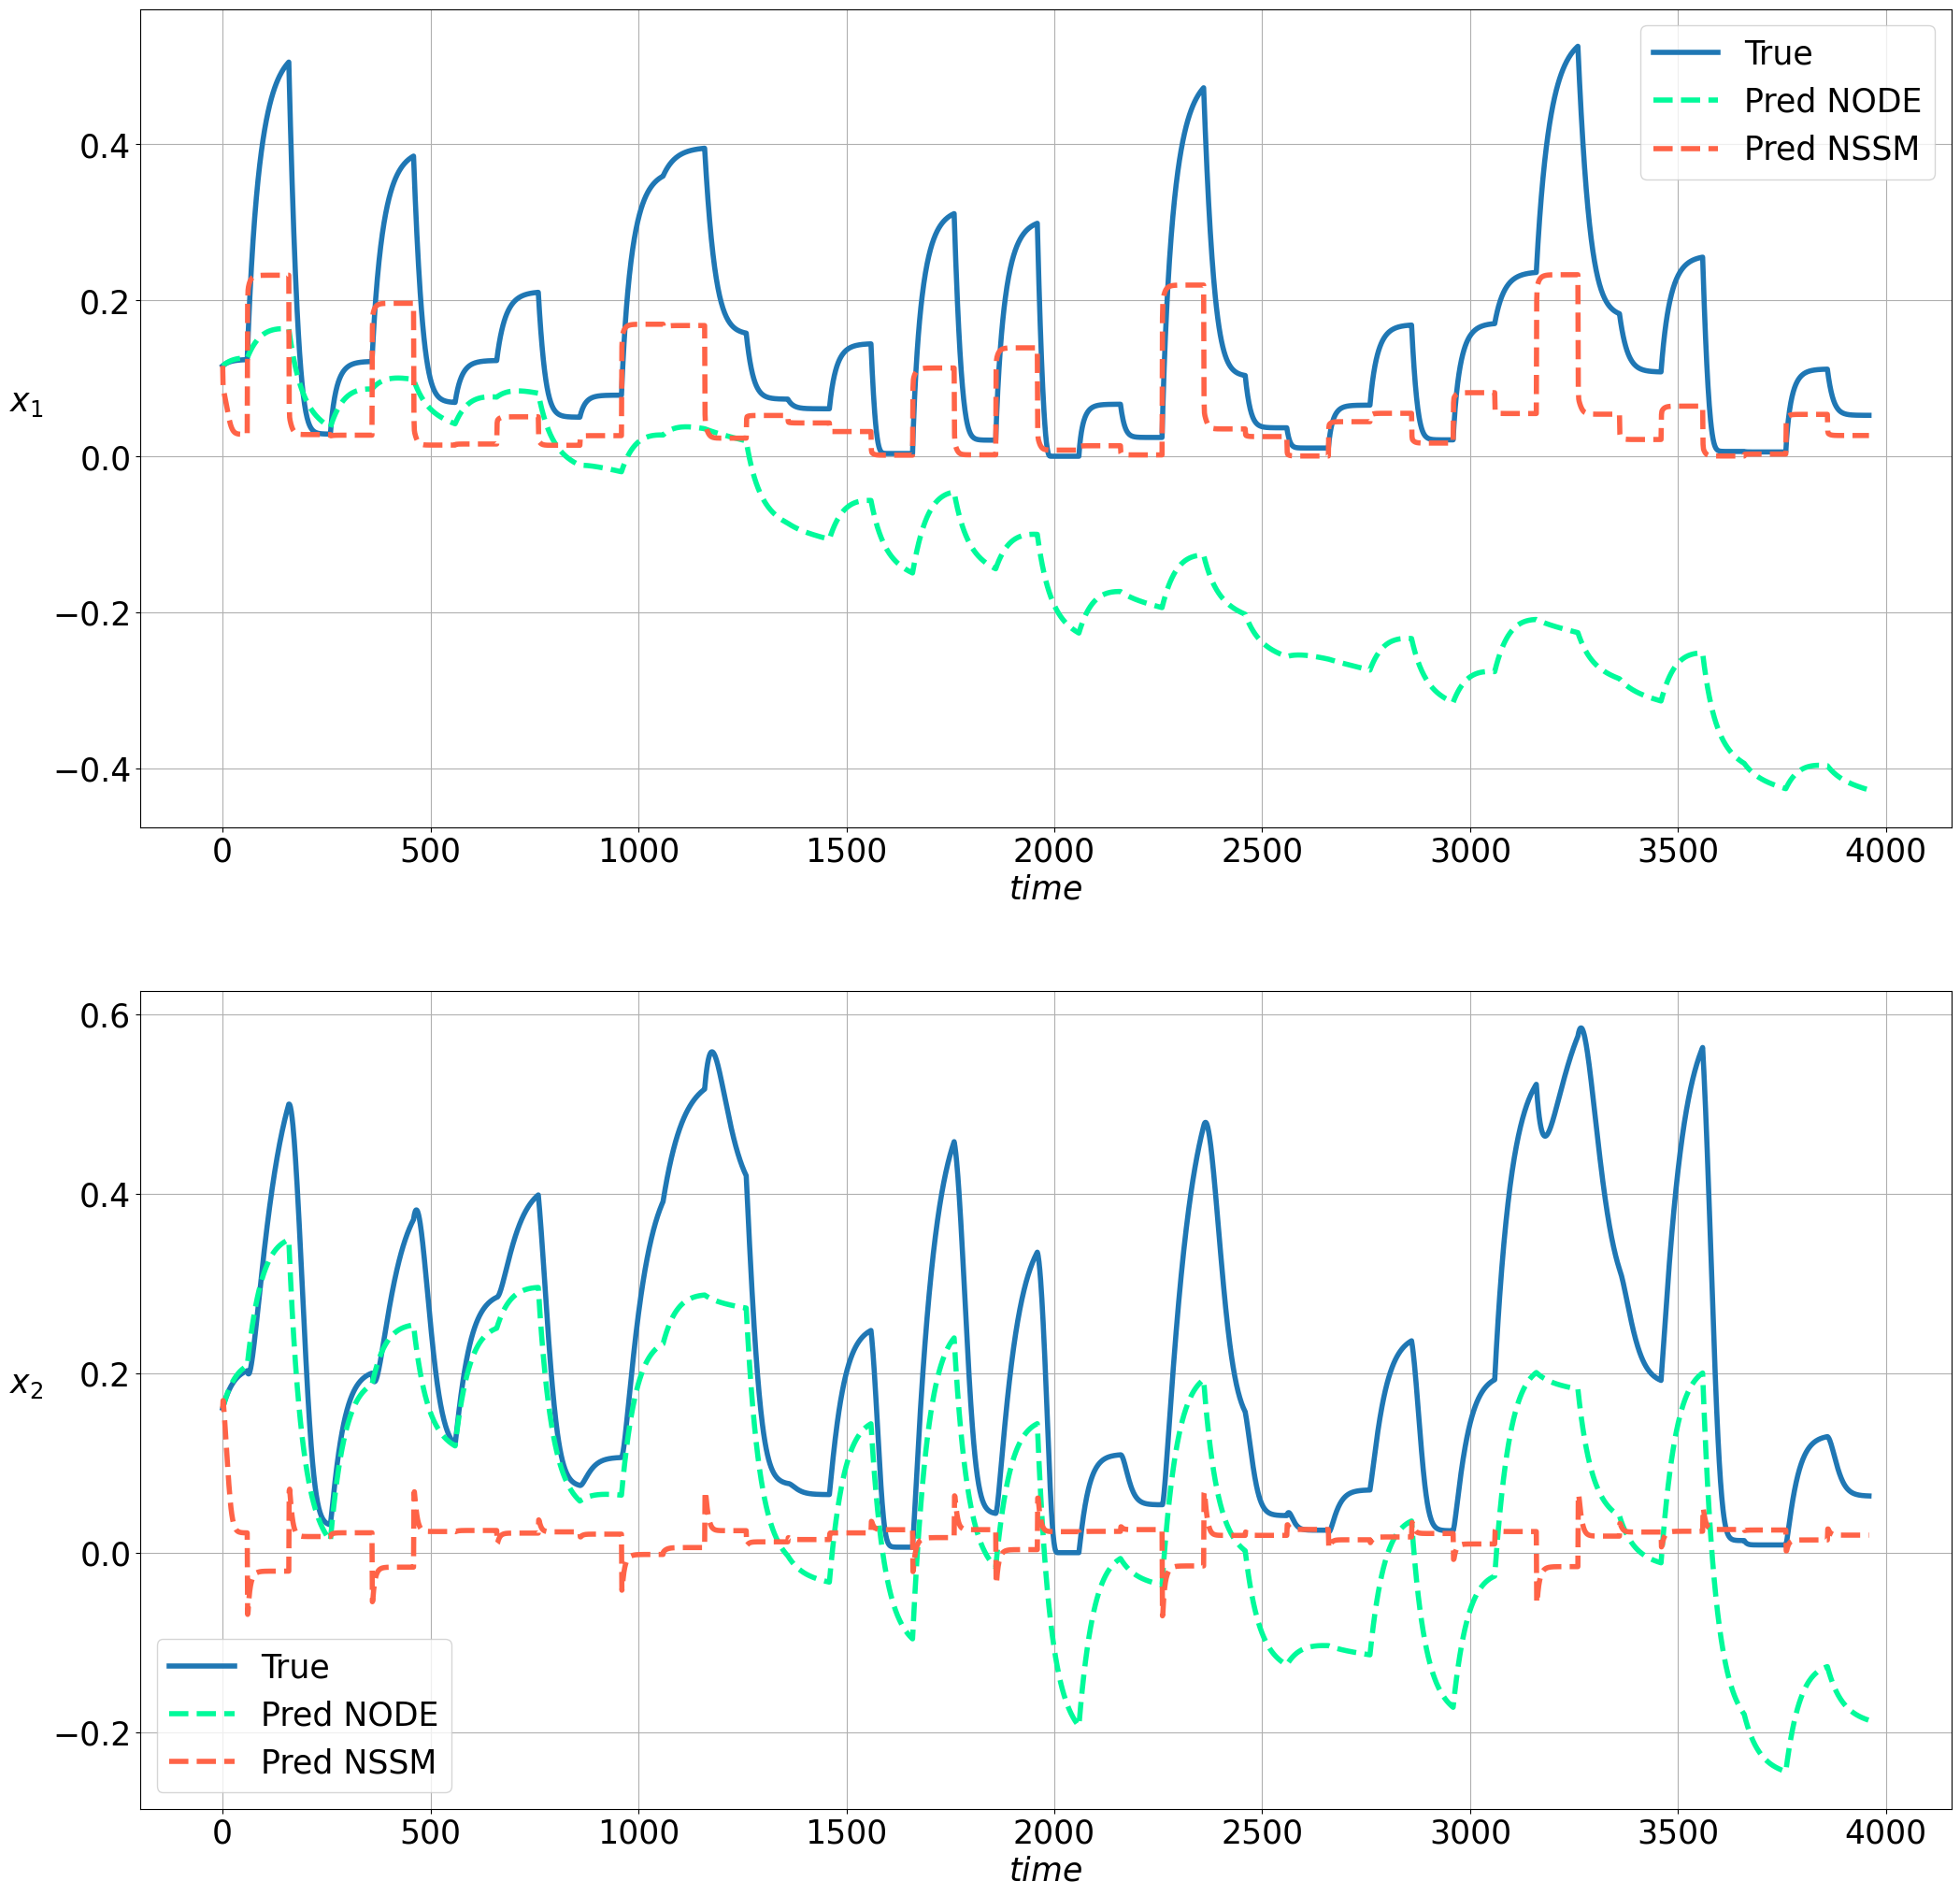

In [24]:
# plot rollout
figsize = 25
fig, ax = plt.subplots(nx, figsize=(figsize, figsize))
labels = [f'$x_{k+1}$' for k in range(len(true_traj))]
for row, (t1, t2, t3, label) in enumerate(zip(true_traj, pred_traj_NODE, pred_traj_NSSM, labels)):
    if nx > 1:
        axe = ax[row]
    else:
        axe = ax
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1, linewidth=4.0, label='True')
    axe.plot(t2, color='mediumspringgreen', linestyle='--', linewidth=4.0, label='Pred NODE')
    axe.plot(t3, color='tomato', linestyle='--', linewidth=4.0, label='Pred NSSM')
    axe.tick_params(labelbottom=False, labelsize=figsize)
    axe.grid()
    axe.tick_params(labelbottom=True, labelsize=figsize)
    axe.legend(fontsize=figsize)
    axe.set_xlabel('$time$', fontsize=figsize)

Compare models numerically.

In [25]:
mse_node = np.mean((pred_traj_NODE - true_traj) ** 2)
mse_nssm = np.mean((pred_traj_NSSM - true_traj) ** 2)
print(f"The MSE for NODE predictions is {mse_node:.4f} and the MSE for NSSM predictions is {mse_nssm:.4f}.")


The MSE for NODE predictions is 0.0694 and the MSE for NSSM predictions is 0.0399.
